In [1]:
import poloniex

In [2]:
import time

# poloniex APIの準備
polo = poloniex.Poloniex()

# 5分間隔（サンプリング間隔300秒）で100日分読み込む
chart_data = polo.returnChartData('BTC_ETH', period=300, start=time.time()-polo.DAY*100, end=time.time())

In [3]:
# pandasのインポート
import pandas as pd

# pandasにデータの取り込み
df = pd.DataFrame(chart_data)

In [4]:
# 短期線：窓幅1日（5分×12×24）
#data_s = pd.rolling_mean(df['close'], 12 * 24) 
data_s = df['close'].rolling(12 * 24).mean()

# 長期線：窓幅5日（5分×12×24×5）
#data_l = pd.rolling_mean(df['close'], 12 * 24 * 5)
data_l = df['close'].rolling(12 * 24 * 5).mean()

In [5]:
# matplotlibの読み込み
import matplotlib.pyplot as plt
# 描画を綺麗に表示する
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

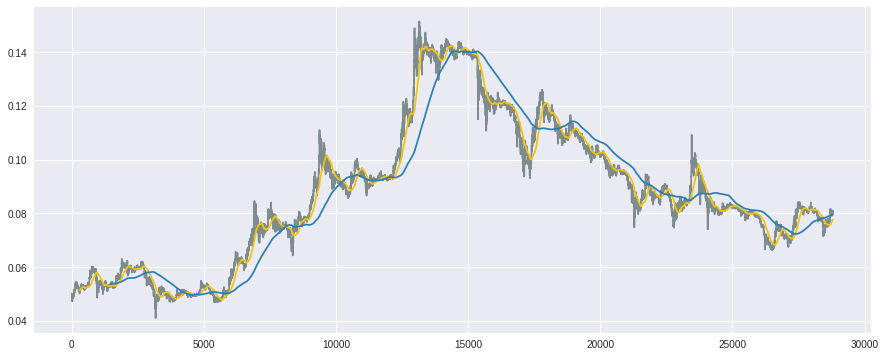

In [6]:
# 短期線と長期線もプロット
plt.plot(df['close'], color='#7f8c8d')
plt.plot(data_s, color='#f1c40f')  # 短期線
plt.plot(data_l, color='#2980b9')  # 長期線
plt.show()

ここからmxnetを使っていく

In [7]:
import logging
logging.getLogger().setLevel(logging.INFO)

# mxnetの読み込み
import mxnet as mx
# GPUがないのでCPUを使うようセット
gpu_device = mx.cpu()

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:32:35.614010. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
# numpyの読み込み
import numpy as np

# API経由では文字列（String型）として受け取るため、float型に変換しておく
data = df['close'].astype(np.float32)

# データを入力変数xと出力変数tに切り分け
x, t = [], []
N = len(data)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
    # 入力変数と出力変数の切り分け
    _x = data[n-M: n] # 入力変数
    _t = data[n] # 出力変数
    # 計算用のリスト(x, t)に追加していく
    x.append(_x)
    t.append(_t)

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:32:39.558070. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
# mxnetのNDArrayの形式に変換する
#x = mx.nd.array(x)
x = mx.nd.array(x).reshape((len(x), M, 1))
# t = mx.nd.array(t).reshape((len(t), 1))
t = mx.nd.array(t)

x.shape

(28770, 30, 1)

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:33:46.207353. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [10]:
# 70%を訓練用、30%を検証用
N_train = int(N * 0.7)
x_train, x_test = x[:N_train], x[N_train:]
t_train, t_test = t[:N_train], t[N_train:]

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:33:59.096325. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:34:05.947586. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:
batch_size = 20
train_iter = mx.io.NDArrayIter(x_train, t_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(x_test, t_test, batch_size)

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:34:11.948139. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [13]:
# 再現性確保
mx.random.seed(1)

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:34:18.466892. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


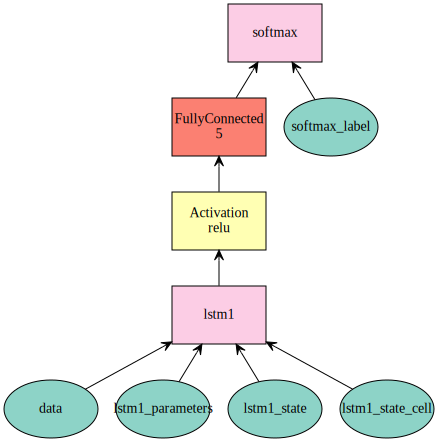

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:34:21.627167. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [14]:
net = mx.sym.Variable('data')
net = mx.sym.RNN(net, name='lstm1', state_size=30, num_layers=1, mode='lstm', p=0.05)
net = mx.sym.Activation(net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=5)
net = mx.sym.SoftmaxOutput(net, name='softmax')
mx.viz.plot_network(net)

In [15]:
mod = mx.mod.Module(symbol=net,
                    context=mx.cpu())
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params()
mod.init_optimizer(optimizer='Adam')

RuntimeError: simple_bind error. Arguments:
data: (20, 30, 1)
softmax_label: (20,)
[09:34:27] src/operator/rnn.cc:14: RNN is only available for gpu at the moment.

Stack trace returned 10 entries:
[bt] (0) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN4dmlc15LogMessageFatalD1Ev+0x29) [0x7efbae974f99]
[bt] (1) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet2op8CreateOpIN7mshadow3cpuEEEPNS_8OperatorENS0_8RNNParamEi+0x3e) [0x7efbafa0e80e]
[bt] (2) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZNK5mxnet2op7RNNProp16CreateOperatorExENS_7ContextEPSt6vectorIN4nnvm6TShapeESaIS5_EEPS3_IiSaIiEE+0x2e) [0x7efbafa0ea5e]
[bt] (3) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet2op19OpPropCreateLayerOpERKN4nnvm9NodeAttrsENS_7ContextERKSt6vectorINS1_6TShapeESaIS7_EERKS6_IiSaIiEE+0x3e8) [0x7efbaf6f61d8]
[bt] (4) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZNSt17_Function_handlerIFN5mxnet10OpStatePtrERKN4nnvm9NodeAttrsENS0_7ContextERKSt6vectorINS2_6TShapeESaIS8_EERKS7_IiSaIiEEEPSH_E9_M_invokeERKSt9_Any_dataS5_S6_SC_SG_+0x15) [0x7efbaf63f435]
[bt] (5) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet4exec13AttachOpExecsEN4nnvm5GraphE+0xc54) [0x7efbafb077b4]
[bt] (6) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet4exec13GraphExecutor15FinishInitGraphEN4nnvm6SymbolENS2_5GraphEPNS_8ExecutorERKSt13unordered_mapINS2_9NodeEntryENS_7NDArrayENS2_13NodeEntryHashENS2_14NodeEntryEqualESaISt4pairIKS8_S9_EEE+0x753) [0x7efbafaf5063]
[bt] (7) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet4exec13GraphExecutor4InitEN4nnvm6SymbolERKNS_7ContextERKSt3mapISsS4_St4lessISsESaISt4pairIKSsS4_EEERKSt6vectorIS4_SaIS4_EESL_SL_RKSt13unordered_mapISsNS2_6TShapeESt4hashISsESt8equal_toISsESaISA_ISB_SN_EEERKSM_ISsiSP_SR_SaISA_ISB_iEEERKSH_INS_9OpReqTypeESaIS12_EERKSt13unordered_setISsSP_SR_SaISsEEPSH_INS_7NDArrayESaIS1C_EES1F_S1F_PSM_ISsS1C_SP_SR_SaISA_ISB_S1C_EEEPNS_8ExecutorERKSM_INS2_9NodeEntryES1C_NS2_13NodeEntryHashENS2_14NodeEntryEqualESaISA_IKS1M_S1C_EEE+0x79c) [0x7efbafaf5c5c]
[bt] (8) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(_ZN5mxnet8Executor10SimpleBindEN4nnvm6SymbolERKNS_7ContextERKSt3mapISsS3_St4lessISsESaISt4pairIKSsS3_EEERKSt6vectorIS3_SaIS3_EESK_SK_RKSt13unordered_mapISsNS1_6TShapeESt4hashISsESt8equal_toISsESaIS9_ISA_SM_EEERKSL_ISsiSO_SQ_SaIS9_ISA_iEEERKSG_INS_9OpReqTypeESaIS11_EERKSt13unordered_setISsSO_SQ_SaISsEEPSG_INS_7NDArrayESaIS1B_EES1E_S1E_PSL_ISsS1B_SO_SQ_SaIS9_ISA_S1B_EEEPS0_+0x3a8) [0x7efbafaf6518]
[bt] (9) /home/jovyan/mxnet/python/mxnet/../../lib/libmxnet.so(MXExecutorSimpleBind+0x2629) [0x7efbafab8969]


/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 09:34:27.247289. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
# mod.fit(train_iter, num_epoch=5, ...)  # train

# use accuracy as the metric
metric = mx.metric.create('acc')
# train 5 epochs, i.e. going over the data iter one pass
for epoch in range(5):
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        mod.forward(batch, is_train=True)       # compute predictions
        mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
        mod.backward()                          # compute gradients
        mod.update()                            # update parameters
    print('Epoch %d, Training %s' % (epoch, metric.get()))

In [ ]:
y = mod.predict(val_iter)
score = mod.score(val_iter, ['mse', 'acc'])
print("Accuracy score is %f" % (score[1][1]))

In [ ]:
from mxnet import gluon

net = gluon.nn.Sequential()
with net.name_scope():
#    net.add(gluon.rnn.LSTM(30, dropout=0.05))
    net.add(gluon.nn.Dense(30, activation='relu'))
    net.add(gluon.nn.Dense(1, in_units=30))

net.collect_params().initialize(ctx=mx.cpu())

In [ ]:
optimizer = gluon.Trainer(net.collect_params(), 'Adam', {})

In [ ]:
metric = mx.metric.Accuracy()
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [23]:
epochs = 30
for epoch in range(epochs):
    # reset data iterator and metric at begining of epoch.
    metric.reset()
#    data_iter = mx.io.NDArrayIter(data=x_train, label=t_train, batch_size=30)
#    for batch in data_iter:
#        with mx.autograd.record():
#            output = net(mx.nd.array(batch.data))
#            L = loss(output, batch.label)
#            L.backward()
#        optimizer.step(batch.data.shape[0])
#        metric.update([batch.label], [output])
    for data, label in train:
        with mx.autograd.record():
            output = net(mx.nd.array(data))
            for i in range(output.size):
                L = loss(output[i], label)
                L.backward()
                metric.update([label], [output[i]])
        optimizer.step(data.shape[0])
        
    name, acc = metric.get()
    print('[Epoch %d] Training: %s=%f'%(epoch, name, acc))

    metric.reset()
#    test_iter = mx.io.NDArrayIter(data=x_test, label=t_test, batch_size=30)
    for data, label in test:
        output = net(mx.nd.array(data))
        for i in range(output.size):
            metric.update([label], [output[i]])
    
    name, val_acc = metric.get()
    print('[Epoch %d] Validation: %s=%f'%(epoch, name, val_acc))

[Epoch 0] Training: accuracy=1.000000
[Epoch 0] Validation: accuracy=1.000000
[Epoch 1] Training: accuracy=1.000000
[Epoch 1] Validation: accuracy=1.000000
[Epoch 2] Training: accuracy=1.000000
[Epoch 2] Validation: accuracy=1.000000
[Epoch 3] Training: accuracy=1.000000
[Epoch 3] Validation: accuracy=1.000000
[Epoch 4] Training: accuracy=1.000000
[Epoch 4] Validation: accuracy=1.000000
[Epoch 5] Training: accuracy=1.000000
[Epoch 5] Validation: accuracy=1.000000
[Epoch 6] Training: accuracy=1.000000
[Epoch 6] Validation: accuracy=1.000000
[Epoch 7] Training: accuracy=1.000000
[Epoch 7] Validation: accuracy=1.000000
[Epoch 8] Training: accuracy=1.000000
[Epoch 8] Validation: accuracy=1.000000
[Epoch 9] Training: accuracy=1.000000
[Epoch 9] Validation: accuracy=1.000000
[Epoch 10] Training: accuracy=1.000000
[Epoch 10] Validation: accuracy=1.000000
[Epoch 11] Training: accuracy=1.000000
[Epoch 11] Validation: accuracy=1.000000


KeyboardInterrupt: 

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 12:20:03.479261. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [ ]:
from mxnet import gluon

class Net(gluon.HybridBlock):
    def __init__(self, n_units, n_output, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            self.l1 = gluon.rnn.LSTM(n_units, dropout=0.05)
            self.l2 = Dense(n_output)

    def hybrid_forward(self, F, x):
        # F is a function space that depends on the type of x
        # If x's type is NDArray, then F will be mxnet.nd
        # If x's type is Symbol, then F will be mxnet.sym
        print('type(x): {}, F: {}'.format(
                type(x).__name__, F.__name__))
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return h2

In [16]:
# モデルの宣言
net = Net(30, 1)
net.collect_params().initialize()

ValueError: Children of HybridBlock must also be HybridBlock, but LSTM(30, TNC, dropout=0.05) has type <class 'mxnet.gluon.rnn.rnn_layer.LSTM'>. If you are using Sequential, please try HybridSequential instead

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-04 06:28:04.107745. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
